# Exp12: tuning C of char/word /bigram classifiers #

In [37]:
import cPickle

import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

data = pd.read_csv(open('semeval2016-task6-trainingdata.txt'), '\t',
                   index_col=0)
targets = list(data.Target.unique()) + ['All']


macro_f_scorer = make_scorer(fbeta_score,
                             beta=1.0,
                             labels=['AGAINST', 'FAVOR'],
                             average='macro')

char_clf = Pipeline([('vect', CountVectorizer(decode_error='ignore',
                                              lowercase=False,
                                              min_df=5,
                                              ngram_range=(3, 3),
                                              analyzer='char')),
                     ('clf', LinearSVC(class_weight='balanced')
                     #('clf', LogisticRegression(class_weight='balanced')
                     )])

word_clf = Pipeline([('vect', CountVectorizer(decode_error='ignore',
                                              lowercase=False,
                                              ngram_range=(1, 2))),
                     
                     ('clf', LinearSVC(class_weight='balanced')
                     #('clf', LogisticRegression(class_weight='balanced')
                    )])

bigram_clf = Pipeline([('vect', CountVectorizer(decode_error='ignore',
                                                stop_words='english',
                                                lowercase=False)),
                     
                     ('clf', LinearSVC(class_weight='balanced')
                     #('clf', LogisticRegression(class_weight='balanced')
                    )])

classfiers = char_clf, word_clf, bigram_clf
clf_names = 'char_clf', 'word_clf', 'bigram_clf'

table = pd.DataFrame(np.zeros(len(targets) * len(classfiers), 
                      dtype=[('target', 'S32'),
                             ('clf', 'S32'),
                            ('best_mean', 'f'),
                            ('best_std', 'f'),
                            ('select_mean', 'f'),
                            ('select_std', 'f'),
                             ('mean_diff', 'f'),
                             ('std_diff', 'f'),
                             ('best_C', 'f'),
                            ('select_C', 'f')]))


def select_C(results, gamble=0.5):
    """
    select C following the modified "one-standard-error' rule
    """
    best_C = results['score_mean'].idxmax()
    best = results.loc[best_C]
    threshold = best.score_mean - gamble * best.score_std
    select = results[results.score_mean > threshold].iloc[0]
    selected_C = select.name
    return best, select, best_C, selected_C

Atheism
--------------------------------------------------------------------------------
char_clf
--------------------------------------------------------------------------------
            score_mean  score_std
C                                
0.000001      0.372086   0.002048
0.000002      0.372086   0.002048
0.000003      0.372086   0.002048
0.000006      0.372086   0.002048
0.000010      0.372086   0.002048
0.000018      0.372086   0.002048
0.000032      0.372086   0.002048
0.000056      0.382231   0.023598
0.000100      0.391532   0.025335
0.000178      0.519205   0.043062
0.000316      0.590526   0.034785
0.000562      0.629980   0.060815
0.001000      0.632799   0.059254
0.001778      0.648410   0.063543
0.003162      0.662812   0.069901
0.005623      0.659837   0.058624
0.010000      0.669164   0.067922
0.017783      0.661588   0.072322
0.031623      0.655458   0.069763
0.056234      0.646868   0.070295
0.100000      0.642640   0.058139
0.177828      0.638571   0.057909
0.316

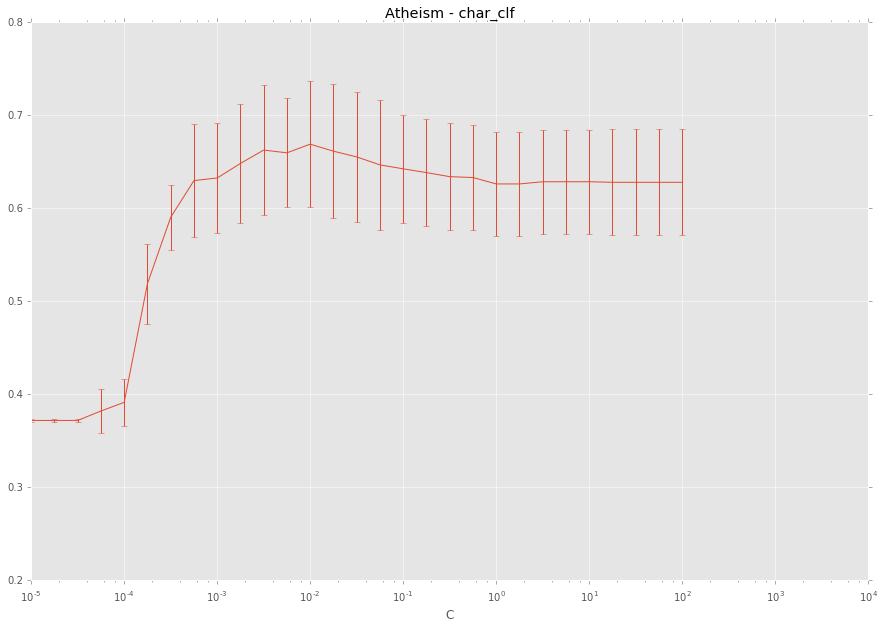

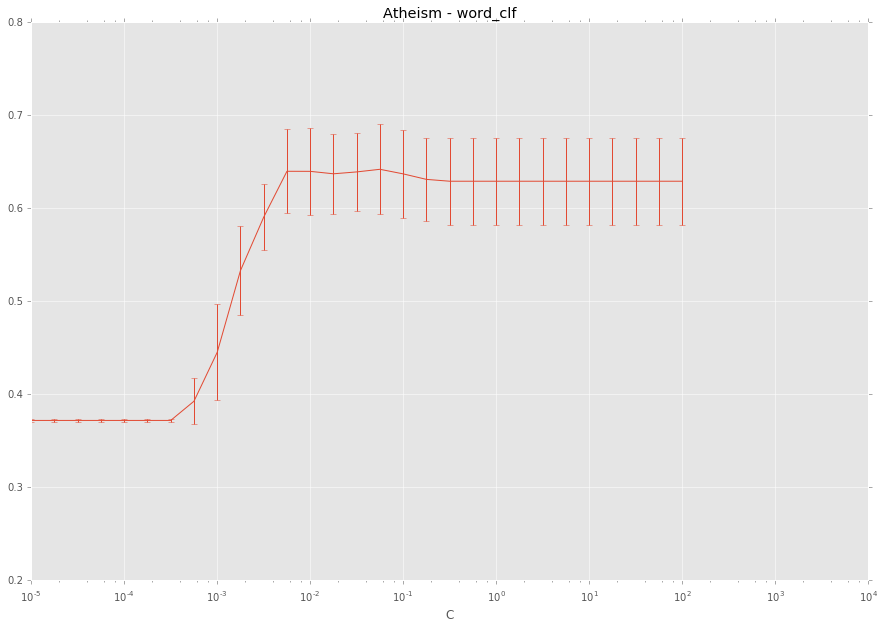

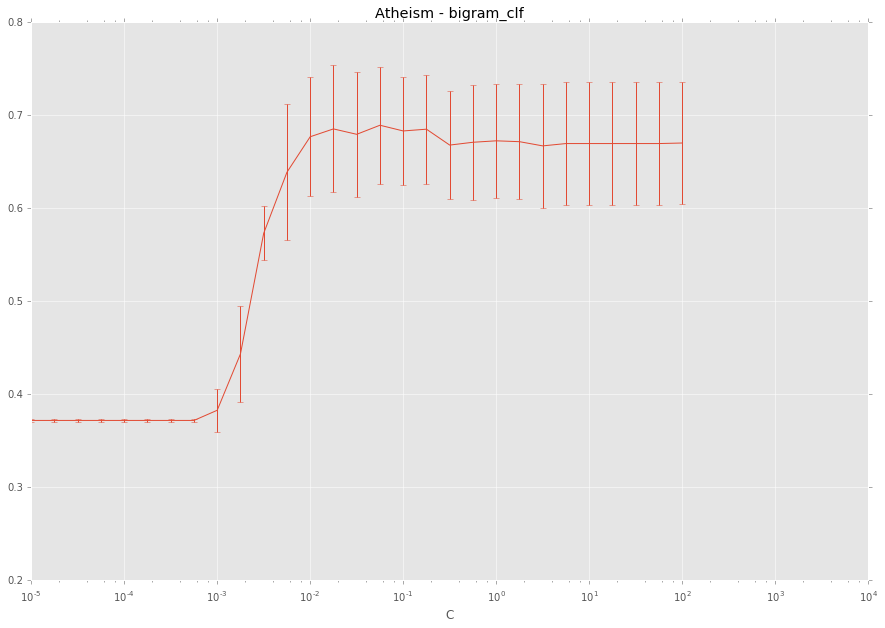

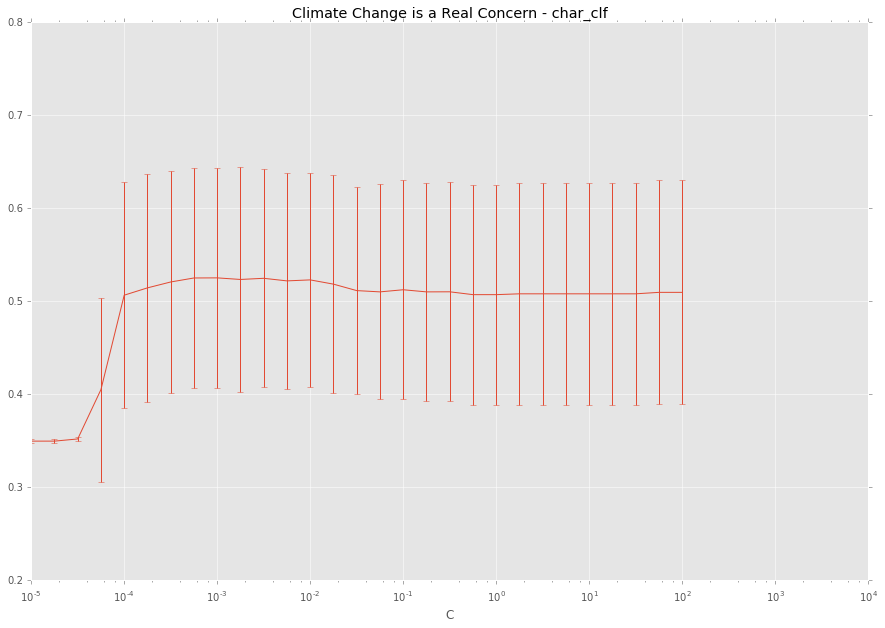

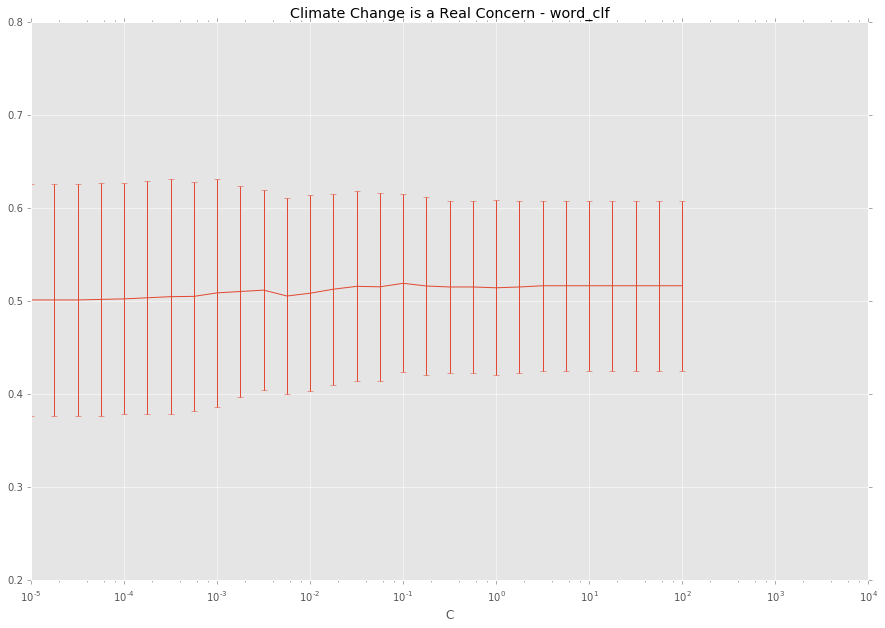

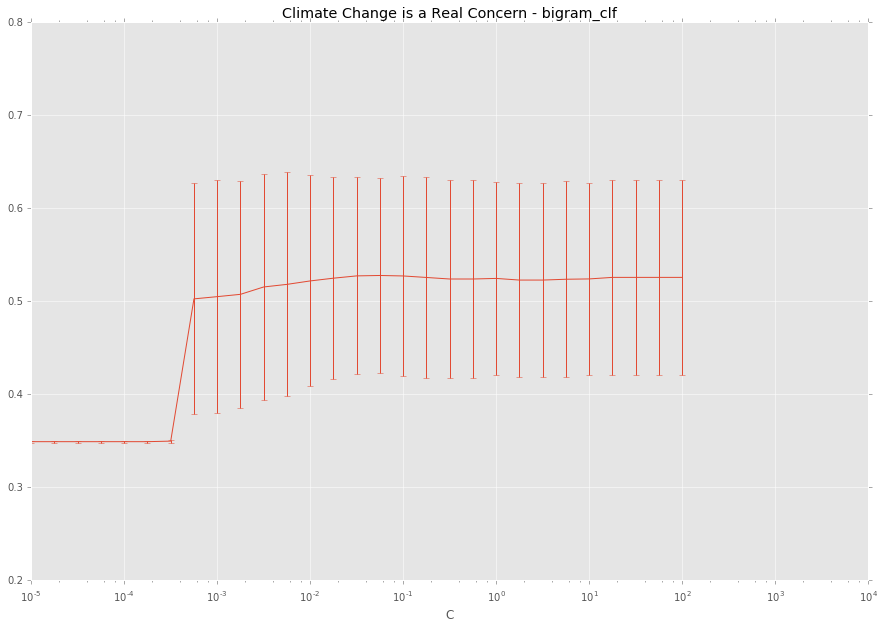

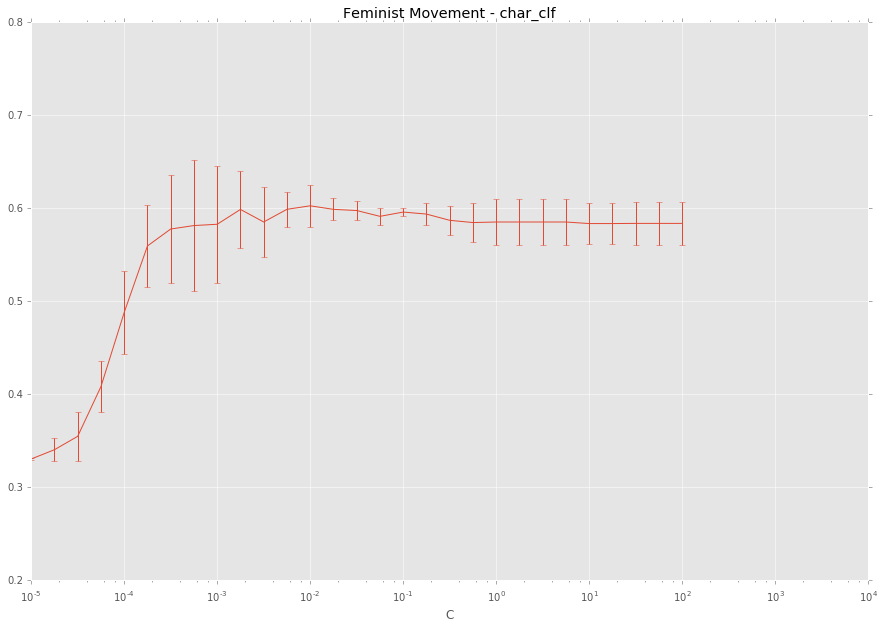

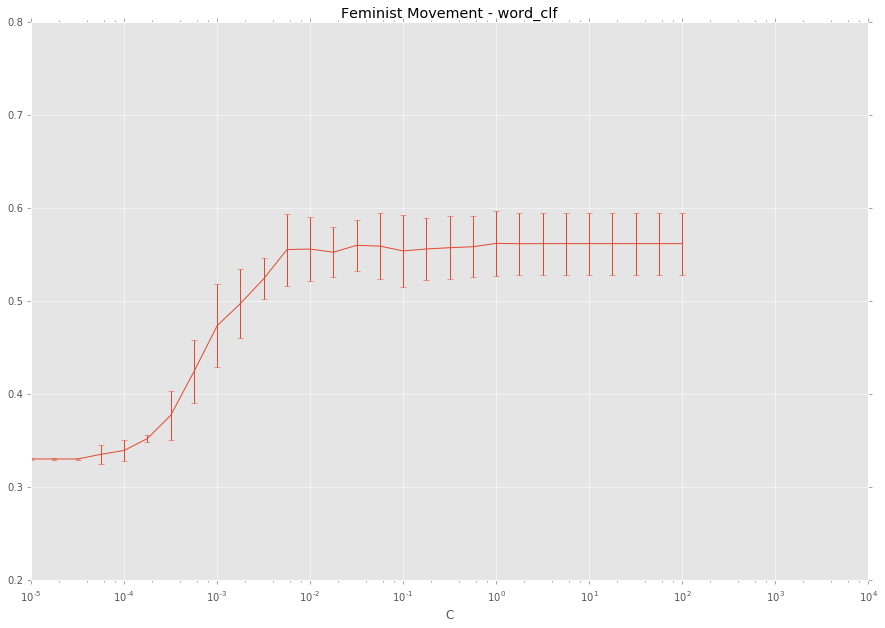

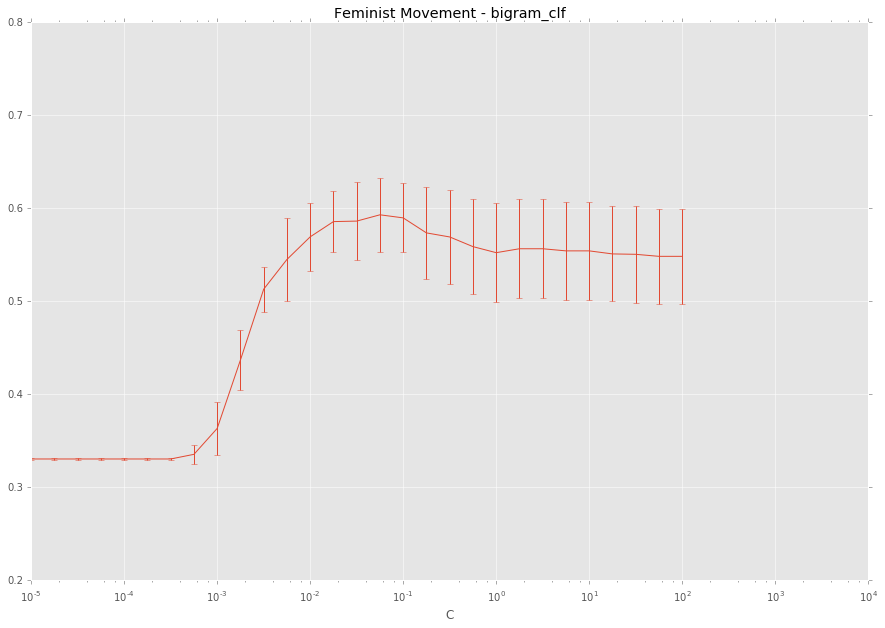

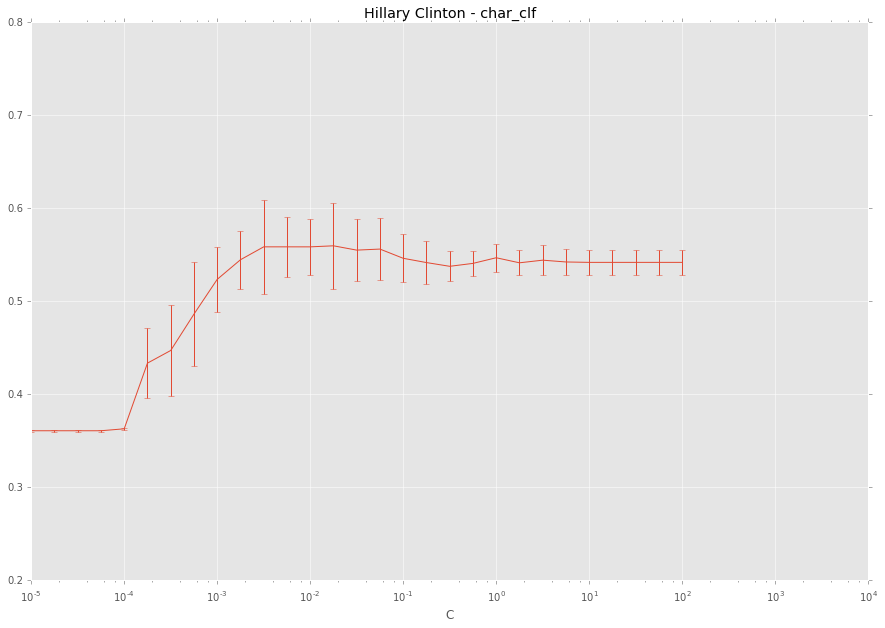

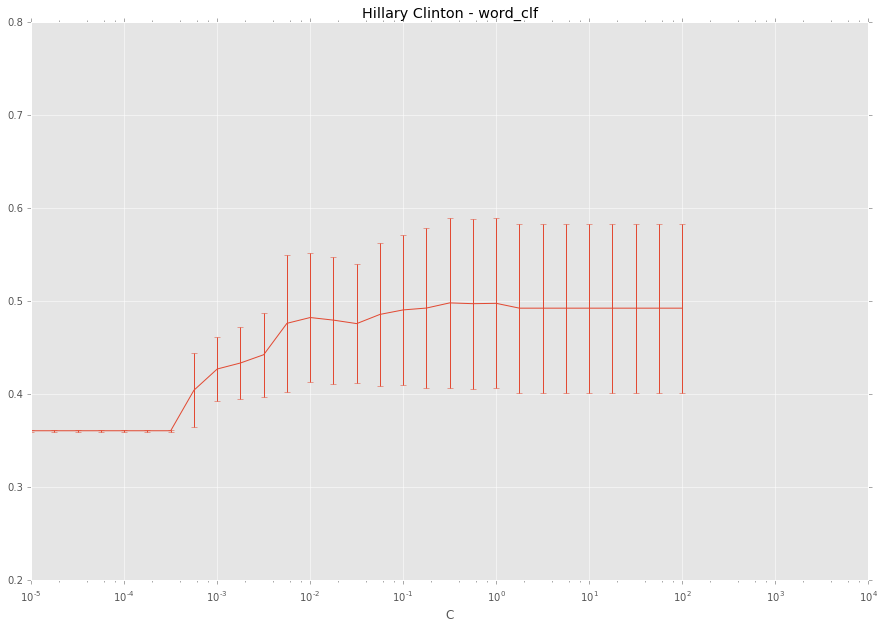

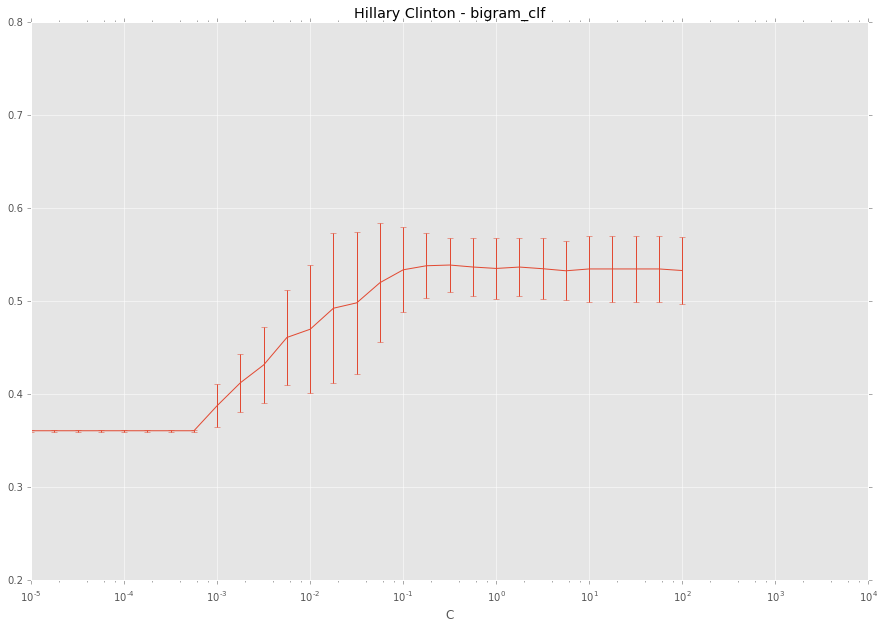

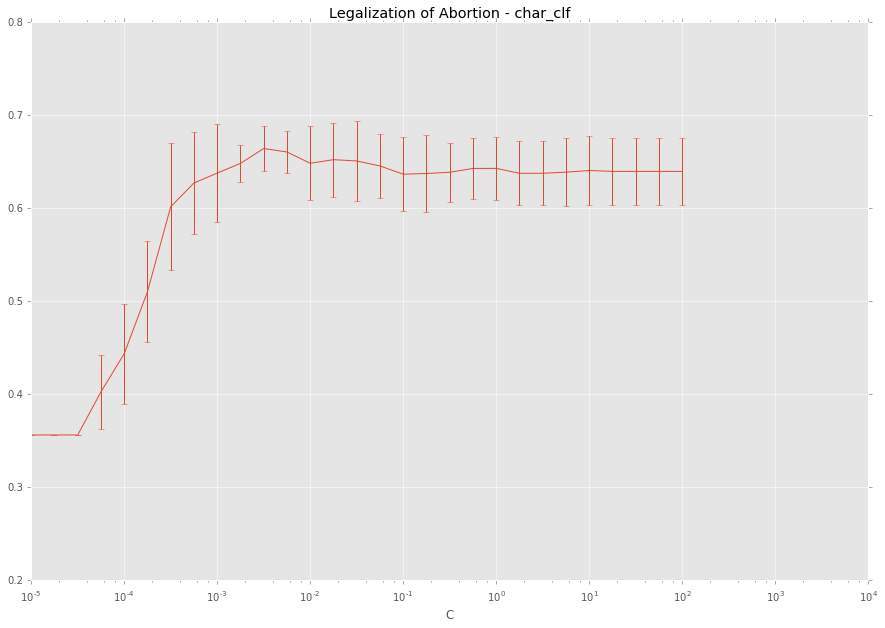

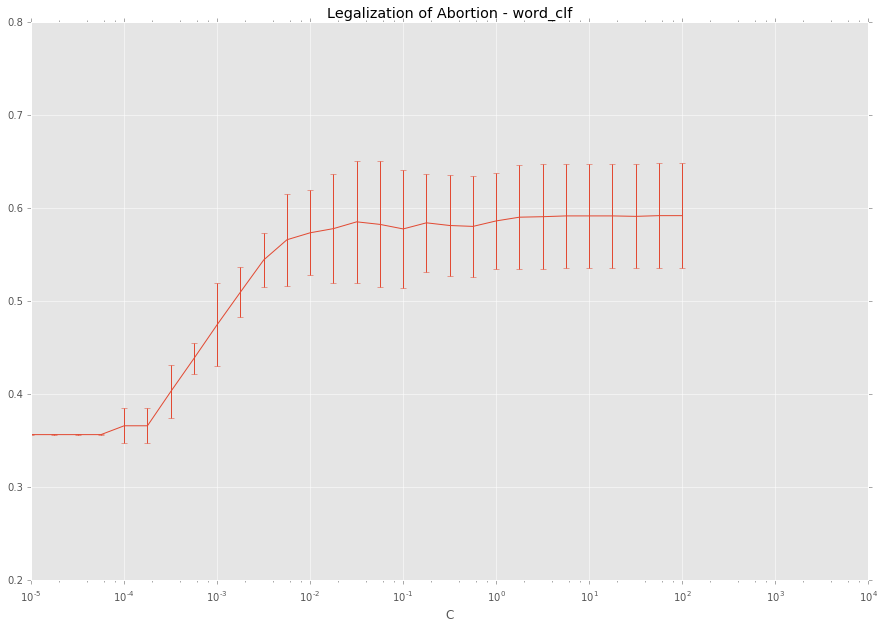

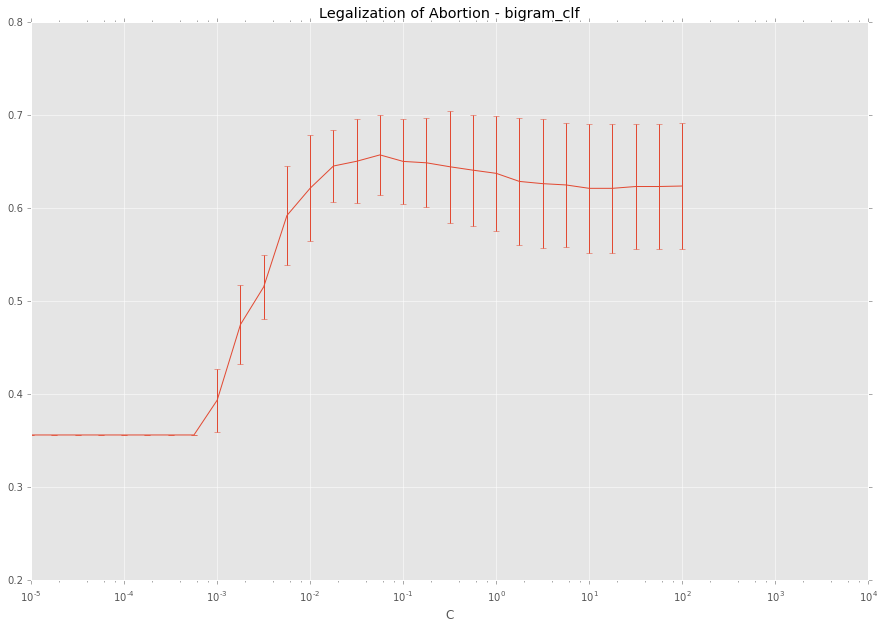

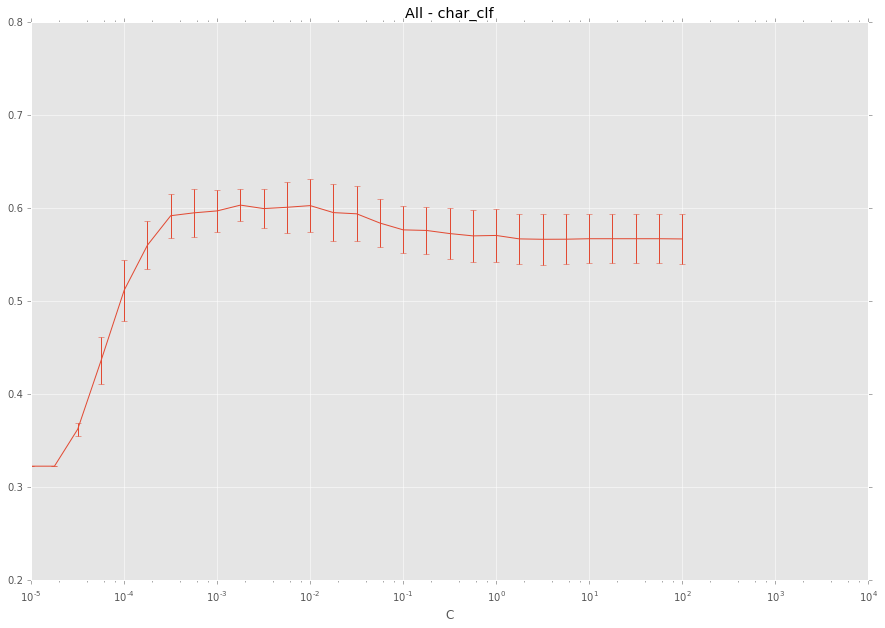

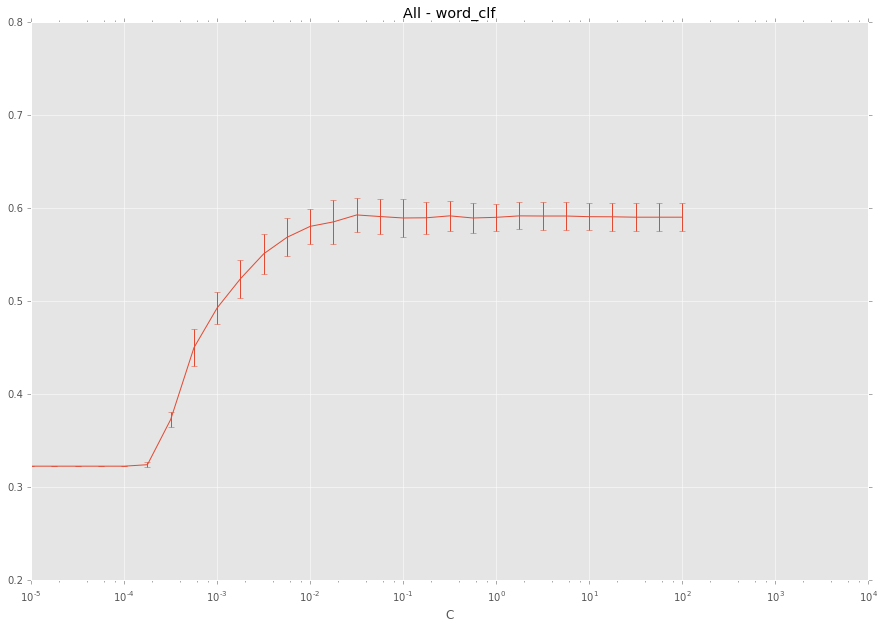

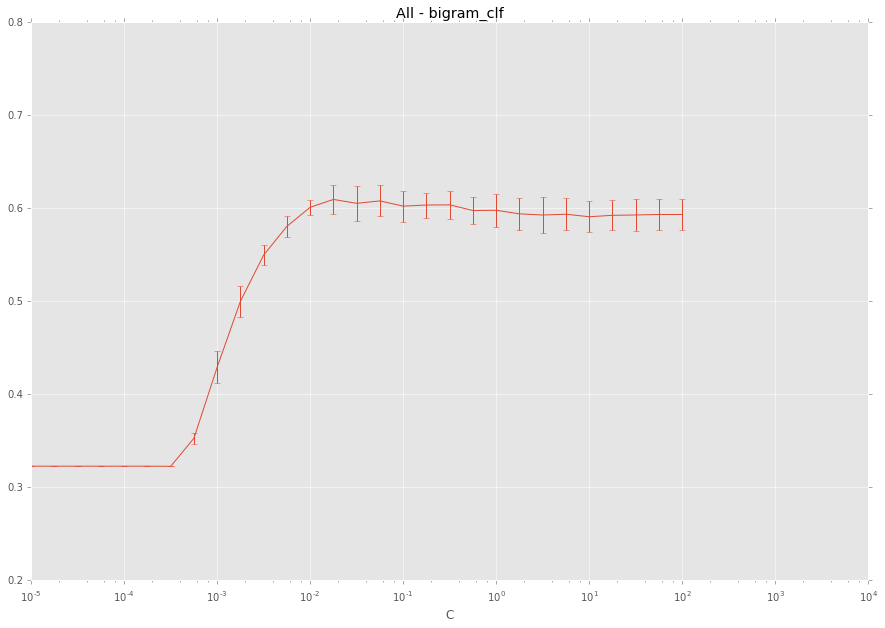

In [42]:
i=0

for target in targets:
    print 80 * "="
    print target
    print 80 * "="
    
    target_data = data[data.Target == target] if target != 'All' else data
    true_stances = target_data.Stance

    params = dict(
        clf__C=np.logspace(-6,2,33)
        #SVC__C=np.hstack([
        #        np.logspace(-6,-2,25), 
        #        np.logspace(-1,2,4)])
        #SVC__C=np.logspace(-5,2,15)
        #SVC__C=[0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
    )

    cv = StratifiedKFold(true_stances, n_folds=5, shuffle=True, random_state=7)

    for clf, clf_name in zip(classfiers, clf_names):
        print 80 * '-'
        print clf_name
        print 80 * '-'

        grid_search = GridSearchCV(clf, params, scoring=macro_f_scorer, cv=cv, n_jobs=4)
        grid_search.fit(target_data.Tweet, true_stances)

        results = []

        for t in grid_search.grid_scores_:
            results.append((
                t.mean_validation_score,
                t.cv_validation_scores.std(),
                t.parameters['clf__C']))

        results = pd.DataFrame(results, columns=['score_mean', 'score_std', 'C'])
        results.set_index('C', inplace=True)
        #results.sort_values(by='score_mean', inplace=True, ascending=False)
        print results

        fig, ax = plt.subplots()
        fig.set_size_inches((15,10))
        xlim = ((10e-6, 10e3))
        results['score_mean'].plot(ax=ax, yerr=results['score_std'], logx=True, ylim=(0.2,0.8), xlim=xlim, 
                                   title=target + ' - ' + clf_name)
        
        best, select, best_C, selected_C = select_C(results)
        table.iloc[i] = ( target, clf_name, 
                         best.score_mean, best.score_std, 
                         select.score_mean, select.score_std, 
                         best.score_mean - select.score_mean,
                         best.score_std - select.score_std,
                         best_C, selected_C )
        i += 1

In [43]:
table

,target,clf,best_mean,best_std,select_mean,select_std,mean_diff,std_diff,best_C,select_C
0,Atheism,char_clf,0.669164,0.067922,0.648410,0.063543,0.020754,0.004379,0.010000,0.001778
1,Atheism,word_clf,0.642130,0.048218,0.639995,0.045317,0.002135,0.002901,0.056234,0.005623
2,Atheism,bigram_clf,0.689507,0.063010,0.677126,0.064172,0.012380,-0.001161,0.056234,0.010000
3,Climate Change is a Real Concern,char_clf,0.525381,0.118044,0.506763,0.121512,0.018618,-0.003468,0.001000,0.000100
4,Climate Change is a Real Concern,word_clf,0.519550,0.095496,0.501631,0.124470,0.017919,-0.028974,0.100000,0.000001
5,Climate Change is a Real Concern,bigram_clf,0.527955,0.104566,0.502802,0.124239,0.025153,-0.019673,0.056234,0.000562
6,Feminist Movement,char_clf,0.602867,0.022563,0.598970,0.041508,0.003896,-0.018945,0.010000,0.001778
7,Feminist Movement,word_clf,0.562489,0.035056,0.555858,0.038712,0.006631,-0.003656,1.000000,0.005623
8,Feminist Movement,bigram_clf,0.593200,0.039679,0.585889,0.032776,0.007311,0.006902,0.056234,0.017783
9,Hillary Clinton,char_clf,0.559859,0.045920,0.544863,0.031403,0.014996,0.014517,0.017783,0.001778


In [41]:
cPickle.dump(table, open('word_bigram_char_svc_c_tuning.pkl', 'wb'))